# Saving and loading models for inference 

In the end, we train models because we want to use them for inference, that is, using them to generate predictions on new targets. The general formula for doing this in FastAI.jl is to first train a `model` for a `method`, for example using [`fitonecycle!`](#) or [`finetune!`](#) and then save the model and the learning method configuration to a file using [`savemethodmodel`](#). In another session you can then use [`loadmethodmodel`](#) to load both. Since the learning method contains all preprocessing logic we can then use [`predict`](#) and [`predictbatch`](#) to generate predictions for new inputs.

Let's fine-tune an image classification model (see [here](./fitonecycle.ipynb) for more info) and go through that process.

In [1]:
using FastAI
using Metalhead

dir = joinpath(datasetpath("dogscats"), "train")
data = loadtaskdata(dir, ImageClassification)
classes = Datasets.getclassesclassification(dir)
method = ImageClassification(classes, (128, 128))
backbone = Metalhead.ResNet50(pretrain=true).layers[1:end-3]
learner = methodlearner(method, data, backbone, ToGPU(), Metrics(accuracy))
finetune!(learner, 3)

Epoch 1 TrainingPhase(): 100%|██████████████████████████| Time: 0:04:43:31


┌───────────────┬───────┬─────────┬──────────┐
│         Phase │ Epoch │    Loss │ Accuracy │
├───────────────┼───────┼─────────┼──────────┤
│ TrainingPhase │   1.0 │ 0.64078 │  0.71674 │
└───────────────┴───────┴─────────┴──────────┘


Epoch 1 ValidationPhase(): 100%|████████████████████████| Time: 0:00:12


┌─────────────────┬───────┬─────────┬──────────┐
│           Phase │ Epoch │    Loss │ Accuracy │
├─────────────────┼───────┼─────────┼──────────┤
│ ValidationPhase │   1.0 │ 0.45262 │  0.78248 │
└─────────────────┴───────┴─────────┴──────────┘


Epoch 2 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:25


┌───────────────┬───────┬─────────┬──────────┐
│         Phase │ Epoch │    Loss │ Accuracy │
├───────────────┼───────┼─────────┼──────────┤
│ TrainingPhase │   2.0 │ 0.39464 │  0.82457 │
└───────────────┴───────┴─────────┴──────────┘


Epoch 2 ValidationPhase(): 100%|████████████████████████| Time: 0:00:04


┌─────────────────┬───────┬─────────┬──────────┐
│           Phase │ Epoch │    Loss │ Accuracy │
├─────────────────┼───────┼─────────┼──────────┤
│ ValidationPhase │   2.0 │ 0.32181 │  0.87543 │
└─────────────────┴───────┴─────────┴──────────┘


Epoch 3 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:23


┌───────────────┬───────┬─────────┬──────────┐
│         Phase │ Epoch │    Loss │ Accuracy │
├───────────────┼───────┼─────────┼──────────┤
│ TrainingPhase │   3.0 │ 0.30739 │  0.86842 │
└───────────────┴───────┴─────────┴──────────┘


Epoch 3 ValidationPhase(): 100%|████████████████████████| Time: 0:00:04


┌─────────────────┬───────┬─────────┬──────────┐
│           Phase │ Epoch │    Loss │ Accuracy │
├─────────────────┼───────┼─────────┼──────────┤
│ ValidationPhase │   3.0 │ 0.27767 │  0.90054 │
└─────────────────┴───────┴─────────┴──────────┘


Epoch 4 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:23


┌───────────────┬───────┬─────────┬──────────┐
│         Phase │ Epoch │    Loss │ Accuracy │
├───────────────┼───────┼─────────┼──────────┤
│ TrainingPhase │   4.0 │ 0.23482 │  0.90418 │
└───────────────┴───────┴─────────┴──────────┘


Epoch 4 ValidationPhase(): 100%|████████████████████████| Time: 0:00:04


┌─────────────────┬───────┬─────────┬──────────┐
│           Phase │ Epoch │    Loss │ Accuracy │
├─────────────────┼───────┼─────────┼──────────┤
│ ValidationPhase │   4.0 │ 0.28883 │  0.90372 │
└─────────────────┴───────┴─────────┴──────────┘


Learner()

Now we can save the model using [`savemethodmodel`](#).

In [6]:
savemethodmodel("catsdogs.jld2", method, learner.model, force = true)

In another session we can now use [`loadmethodmodel`](#) to load both model and learning method from the file. Since the model weights are transferred to the CPU before being saved, we need to move them to the GPU manually if we want to use that for inference. 

In [3]:
method, model = FastAI.loadmethodmodel("catsdogs.jld2")
model = gpu(model);

Finally, let's select the first 8 cat images from the dataset and see if the model classifies them correctly:

In [4]:
# use it for inference
images = [getobs(data.input, i) for i in rand(1:nobs(data), 9)]
preds = predictbatch(method, model, images; device = gpu, context = Validation())

9-element Vector{SubString{String}}:
 "cats"
 "dogs"
 "dogs"
 "dogs"
 "dogs"
 "cats"
 "dogs"
 "cats"
 "cats"

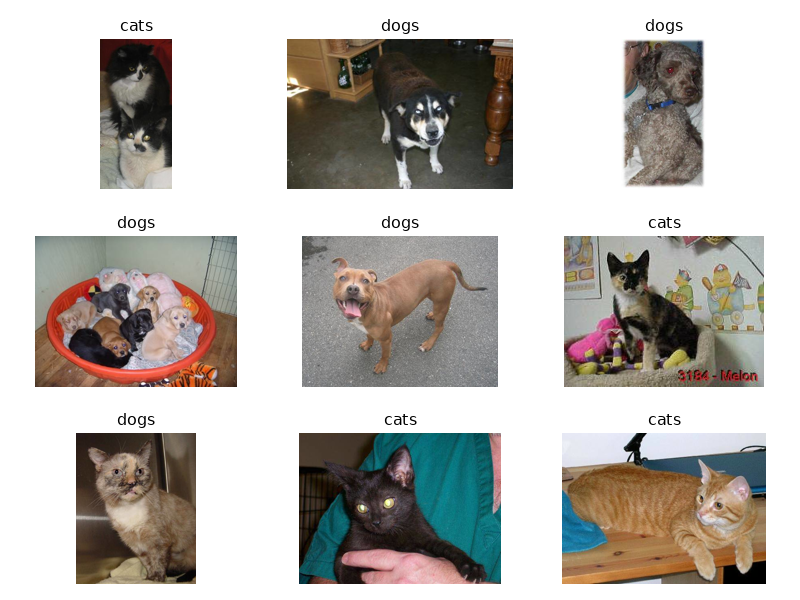

In [5]:
using CairoMakie
plotsamples(method, collect(zip(images, preds)))